# Analyze posts

Crawler vocabulary:

* 20241123: initial vocabulary (20): aan als bij dat de een en er geen het met niet op te van voor wel ze zijn zo
* 20241226 10:50 added (12): ik is in je maar die ook wat dan nog om dit

In [1]:
import datetime
from dateutil import parser
import gzip
import json
import langdetect
import matplotlib
import matplotlib.pyplot as plt
import os
import pandas as pd
import polars as pl
import random
import regex
import spacy
import sys
import unittest
import uuid
import wordcloud
import zipfile
import IPython.display

from IPython.display import Image
from IPython.core.display import HTML
from sklearn.decomposition import PCA

sys.path.insert(0, '../scripts')
import tscore

In [2]:
POSTS_DIR = "../../posts"

In [3]:
nlp = spacy.load("nl_core_news_sm")

In [4]:
from IPython.core.display import HTML

def left_align_markdown_tables():
    return HTML("""
<style>
table {
    margin-left: 0 !important;
}
</style>
""")

left_align_markdown_tables()

## 0. Read posts from zip files (SKIP)

In [4]:
BASEDIR = '/home/erikt/software/bsky/zipfiles'

In [5]:
def make_tmp_dir():
    while True:
        tmp_dir_name = os.path.join('/tmp', str(uuid.uuid4()))
        if not os.path.exists(tmp_dir_name):
            break
    os.mkdir(tmp_dir_name)
    return tmp_dir_name

In [6]:
def read_posts_from_file(infile, posts_texts):
    data = json.load(infile)
    for post in data['posts']:
        date = post['record']['createdAt'][:10]
        if date not in post_texts:
            post_texts[date] = {}
        if post['cid'] not in post_texts[date]:
            post_texts[date][post['cid']] = {'createdAt': post['record']['createdAt'],
                                             'handle': post['author']['handle'],
                                             'text': post['record']['text']}

In [7]:
def unpack_zipfile(zipfile_name, tmp_dir_name):
    month = zipfile_name[:6]
    with zipfile.ZipFile(os.path.join(BASEDIR, month, zipfile_name), 'r') as zipfile_handle:
        zipfile_handle.extractall(tmp_dir_name)

In [8]:
tmp_dir_name = make_tmp_dir()

In [9]:
post_texts = {}

for month in ['202505']:
    for zipfile_name in sorted(os.listdir(os.path.join(BASEDIR, month))):
        if len(os.listdir(tmp_dir_name)) != 0:
            print(f'warning: number of data files in temporary directory: {len(os.listdir(tmp_dir_name))}')
        unpack_zipfile(zipfile_name, tmp_dir_name)
        for file_name in sorted(os.listdir(tmp_dir_name)):
            file_name_with_dir = os.path.join(tmp_dir_name, file_name)
            with gzip.open(file_name_with_dir, "r") as infile:
                try:
                    read_posts_from_file(infile, post_texts)
                except:
                    print(f'problem processing file {file_name}')
                infile.close()
                os.remove(file_name_with_dir)
        print(f'finished processing file {zipfile_name}')

finished processing file 20250501.zip
finished processing file 20250502.zip
finished processing file 20250503.zip
finished processing file 20250504.zip
finished processing file 20250505.zip
finished processing file 20250506.zip
finished processing file 20250507.zip
finished processing file 20250508.zip
finished processing file 20250509.zip
finished processing file 20250510.zip
finished processing file 20250511.zip
finished processing file 20250512.zip
finished processing file 20250513.zip
finished processing file 20250514.zip
finished processing file 20250515.zip
finished processing file 20250516.zip
finished processing file 20250517.zip
finished processing file 20250518.zip
finished processing file 20250519.zip
finished processing file 20250520.zip
finished processing file 20250521.zip
finished processing file 20250522.zip
finished processing file 20250523.zip
finished processing file 20250524.zip
finished processing file 20250525.zip
finished processing file 20250526.zip
finished pro

In [10]:
for date in post_texts.keys():
    print(date, len(post_texts[date]))

2025-04-30 1476
2025-05-01 20918
2025-07-01 1
2025-05-02 21213
2025-05-03 21423
2025-05-04 21170
2025-05-05 22930
2025-05-06 20265
2025-05-07 21873
2025-05-08 22256
2025-05-09 22205
2025-05-10 20771
2025-05-11 20695
2025-05-12 21174
2025-05-13 24454
2025-05-14 22517
2025-05-15 23621
2025-05-16 22447
2025-05-17 23484
2025-05-18 22713
2025-05-19 20942
2025-05-20 21994
2025-05-21 22496
2025-05-22 21144
2025-05-23 20332
2025-05-24 22897
2025-05-25 20067
2025-05-26 24451
2025-05-27 22500
2025-05-28 22605
2025-05-29 22208
2025-05-30 20541
2025-05-31 19953


In [11]:
len(post_texts)

33

In [15]:
for year_month in ['202505']:
    year = year_month[:4]
    month = year_month[4:]
    save_post_texts_json({key: post_texts[key] for key in post_texts.keys() if regex.search(f'^{year}-{month}', key)}, outfile_name=f'{year_month}.json')

In [17]:
os.rmdir(tmp_dir_name)

## 1. Check duplicate posts per batch (SKIP)

In [ ]:
crawler_vocabulary = ['de','het','een','en','ik','van','dat','is','in','niet','op','voor','wel',
                      'met','zijn','te','er','zo','aan','ze','als','bij','geen',
                      'je','maar','die','ook','wat','dan','nog','om','dit']

In [ ]:
def collect_posts(word='', date=''):
    posts = {}
    for file_name in os.listdir(POSTS_DIR):
        if regex.search('-' + word + '\\.', file_name) and regex.search(date, file_name):
            with open(os.path.join(POSTS_DIR, file_name), "r") as infile:
                try:
                    data = json.load(infile)
                    infile.close()
                    posts[file_name] = [post['cid'] for post in data['posts']]
                except:
                    pass
    return posts

In [ ]:
def count_unique_posts(posts):
    unique_posts = set()
    for sample_time in posts.keys():
        duplicate_posts = set(posts[sample_time]) & unique_posts
        new_posts = set(posts[sample_time]).difference(duplicate_posts)
        unique_posts = unique_posts | new_posts
    return list(unique_posts)

In [ ]:
def compare_posts(posts, n=1):
    sample_times = sorted(posts.keys())
    overlap_counts = []
    for i in range(0, len(sample_times)):
        if i + n < len(sample_times):
            intersection = (set(posts[sample_times[i]]) & set(posts[sample_times[i + n]]))
            overlap_counts.append(len(intersection))
    print(f"min={min(overlap_counts):<2}", 
          f"max={max(overlap_counts):<3}", 
          f"avg={round(sum(overlap_counts) / len(overlap_counts), 1)}")

In [ ]:
for word in crawler_vocabulary:
    posts = collect_posts(word=word, date='2024-12-26')
    print(f"{word:>4}", end=" ")
    compare_posts(posts)

In [ ]:
len(count_unique_posts(posts))

In [ ]:
def get_new_post_ids(word, post_ids={}, date=''):
    for file_name in sorted(os.listdir(POSTS_DIR)):
        if regex.search('-' + word + '\\.', file_name) and regex.search(date, file_name):
            with open(os.path.join(POSTS_DIR, file_name), "r") as infile:
                try:
                    data = json.load(infile)
                    infile.close()
                    for post_id in [post['cid'] for post in data['posts']]:
                        if post_id not in post_ids:
                            post_ids[post_id] = True
                except:
                    pass
    return post_ids

In [ ]:
post_ids = {}
last_count = 0
date = '2024-12-26'
for word in crawler_vocabulary:
    post_ids = get_new_post_ids(word, post_ids, date=date)
    print(word, len(post_ids.keys()) - last_count, end='')
    post_id_sample = list(post_ids.keys())[-1]
    if post_id_sample in post_texts[date]:
        post_text = post_texts[date][post_id_sample].translate(str.maketrans({'\n': ' '}))
        print(f' [{langdetect.detect(post_text)}] {post_text}', end = '')
    print('')
    last_count = len(post_ids.keys())

## 2. Read posts from crawler files (SKIP)

In [13]:
JSON_POST_TEXTS_FILE_NAME = "post_texts.json"
JSON_POST_AUTHORS_FILE_NAME = "post_authors.json"
JSON_POST_HOURS_FILE_NAME = "post_hours.json"

In [14]:
def save_post_texts_json(post_texts, outfile_name=JSON_POST_TEXTS_FILE_NAME):
    with open(outfile_name, "w") as outfile:
        json.dump(post_texts, outfile)
        outfile.close()

In [ ]:
def get_post_texts(post_texts = {}):
    last_date = ""
    processed_dates = list(post_texts.keys())
    for dir_name in sorted(os.listdir(POSTS_DIR)):
        full_dir = os.path.join(POSTS_DIR, dir_name)
        for file_name in sorted(os.listdir(full_dir)):
            date = file_name[:10]
            if not regex.search("^2", date) or date in processed_dates: 
                continue
            if date != last_date:
                if last_date in post_texts:
                    print(last_date, len(post_texts[last_date]))
                last_date = date
            with open(os.path.join(full_dir, file_name), "r") as infile:
                try:
                    data = json.load(infile)
                    infile.close()
                    for post in data['posts']:
                        date = post['record']['createdAt'][:10]
                        if date not in post_texts:
                            post_texts[date] = {}
                        if post['cid'] not in post_texts[date]:
                            post_texts[date][post['cid']] = post['record']['text']
                except:
                    pass
                infile.close()
    if last_date in post_texts:
        print(last_date, len(post_texts[last_date]))
    return post_texts

In [ ]:
def get_post_authors():
    post_authors = {}
    last_date = ""
    for file_name in sorted(os.listdir(POSTS_DIR)):
        date = file_name[:10]
        if not regex.search("^2", date):
            continue
        if date != last_date:
            if last_date in post_authors:
                print(last_date, len(post_authors[last_date]))
            last_date = date
        with open(os.path.join(POSTS_DIR, file_name), "r") as infile:
            try:
                data = json.load(infile)
                infile.close()
                for post in data['posts']:
                    date = post['record']['createdAt'][:10]
                    if date not in post_authors:
                        post_authors[date] = {}
                    if post['cid'] not in post_authors[date]:
                        post_authors[date][post['cid']] = post['author']['handle']
            except:
                pass
            infile.close()
    if last_date in post_authors:
        print(last_date, len(post_authors[last_date]))
    return post_authors

In [ ]:
def get_post_hours():
    post_hours = {}
    last_date = ""
    for file_name in sorted(os.listdir(POSTS_DIR)):
        date = file_name[:10]
        if not regex.search("^2", date):
            continue
        if date != last_date:
            if last_date in post_hours:
                print(last_date, len(post_hours[last_date]))
            last_date = date
        with open(os.path.join(POSTS_DIR, file_name), "r") as infile:
            try:
                data = json.load(infile)
                infile.close()
                for post in data['posts']:
                    date = post['record']['createdAt'][:10]
                    hour = post['record']['createdAt'][11:13]
                    if date not in post_hours:
                        post_hours[date] = {}
                    if post['cid'] not in post_hours[date]:
                        post_hours[date][post['cid']] = hour
            except:
                pass
            infile.close()
    if last_date in post_hours:
        print(last_date, len(post_hours[last_date]))
    return post_hours

In [ ]:
post_texts = get_post_texts({})

In [ ]:
post_authors = get_post_authors()

In [ ]:
post_hours = get_post_hours()

In [ ]:
#del(post_texts['2024-11-23'])
#del(post_authors['2024-11-23'])
#del(post_hours['2024-11-23'])

In [ ]:
save_post_texts_json(post_texts, outfile_name=JSON_POST_TEXTS_FILE_NAME)
save_post_texts_json(post_authors, outfile_name=JSON_POST_AUTHORS_FILE_NAME)
save_post_texts_json(post_hours, outfile_name=JSON_POST_HOURS_FILE_NAME)

In [ ]:
save_post_texts_json(post_texts, outfile_name=JSON_POST_TEXTS_FILE_NAME)

## 3. Read posts from json files

In [5]:
def read_single_json_file(infile_name):
    """Read data file and return contents as dict"""
    with gzip.open(infile_name, "r") as infile:
        post_texts = json.load(infile)
        infile.close()
    return post_texts

In [6]:
MONTHS = ['202412', '202501', '202502', '202503', '202504', '202505'] # skipping 202411

def read_all_json_files():
    """Read all data files and return contents as dict"""
    post_texts = {}
    for month in MONTHS:
        file_name = f"{month}.json.gz"
        print(f"Reading {file_name}")
        post_texts = post_texts | read_single_json_file(file_name)
    post_count = sum([len(post_texts[date]) for date in post_texts.keys()])
    print(f"Finished, read {post_count} posts")
    return post_texts

In [7]:
post_texts = read_all_json_files()

Reading 202412.json.gz
Reading 202501.json.gz
Reading 202502.json.gz
Reading 202503.json.gz
Reading 202504.json.gz
Reading 202505.json.gz
Finished, read 4207642 posts


In [8]:
post_texts.keys()

dict_keys(['2024-12-01', '2024-12-02', '2024-12-03', '2024-12-04', '2024-12-05', '2024-12-06', '2024-12-07', '2024-12-08', '2024-12-09', '2024-12-10', '2024-12-11', '2024-12-12', '2024-12-13', '2024-12-14', '2024-12-15', '2024-12-16', '2024-12-17', '2024-12-18', '2024-12-19', '2024-12-20', '2024-12-21', '2024-12-22', '2024-12-23', '2024-12-24', '2024-12-25', '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29', '2024-12-30', '2024-12-31', '2025-01-01', '2025-01-02', '2025-01-03', '2025-01-04', '2025-01-05', '2025-01-06', '2025-01-07', '2025-01-08', '2025-01-09', '2025-01-10', '2025-01-11', '2025-01-12', '2025-01-13', '2025-01-14', '2025-01-15', '2025-01-16', '2025-01-17', '2025-01-18', '2025-01-19', '2025-01-20', '2025-01-21', '2025-01-24', '2025-01-25', '2025-01-26', '2025-01-27', '2025-01-28', '2025-01-29', '2025-01-30', '2025-01-31', '2025-02-01', '2025-02-02', '2025-02-03', '2025-02-04', '2025-02-05', '2025-02-06', '2025-02-07', '2025-02-08', '2025-02-09', '2025-02-10', '2025-02-

## 4. General post stats  (SKIP)

In [7]:
def sanity_check_post_ids(post_texts):
    for date in post_texts.keys():
        for key in post_texts[date].keys():
            for date_2 in post_texts.keys():
                if date_2 != date and key in post_texts[date_2]:
                    print(f'duplicate key! {key} {date} {date_2}')

In [8]:
sanity_check_post_ids(post_texts)

In [9]:
print('Post counts per date:')
{date: len(post_texts[date]) for date in sorted(post_texts.keys())}

Post counts per date:


{'2024-11-23': 7303,
 '2024-11-24': 26794,
 '2024-11-25': 26730,
 '2024-11-26': 27793,
 '2024-11-27': 27685,
 '2024-11-28': 26689,
 '2024-11-29': 25750,
 '2024-11-30': 22997,
 '2024-12-01': 23766,
 '2024-12-02': 24571,
 '2024-12-03': 23941,
 '2024-12-04': 26212,
 '2024-12-05': 24243,
 '2024-12-06': 24477,
 '2024-12-07': 20808,
 '2024-12-08': 21330,
 '2024-12-09': 20631,
 '2024-12-10': 20968,
 '2024-12-11': 21028,
 '2024-12-12': 22508,
 '2024-12-13': 20535,
 '2024-12-14': 19018,
 '2024-12-15': 19033,
 '2024-12-16': 18975,
 '2024-12-17': 20715,
 '2024-12-18': 20620,
 '2024-12-19': 19823,
 '2024-12-20': 19765,
 '2024-12-21': 20429,
 '2024-12-22': 20162,
 '2024-12-23': 20359,
 '2024-12-24': 20320,
 '2024-12-25': 15300,
 '2024-12-26': 16205,
 '2024-12-27': 18529,
 '2024-12-28': 21216,
 '2024-12-29': 20862,
 '2024-12-30': 22340,
 '2024-12-31': 26356,
 '2025-01-01': 22892,
 '2025-01-02': 21971,
 '2025-01-03': 21402,
 '2025-01-04': 20756,
 '2025-01-05': 20704,
 '2025-01-06': 20426,
 '2025-01-0

In [10]:
print('Total number of posts:', sum([len(post_texts[date]) for date in sorted(post_texts.keys())]))

Total number of posts: 3721124


## 5. Search for topics: functions

In [8]:
def count_word(post_texts, word, exact_match=True):
    if word == "":
        return {date: len(post_texts[date]) for date in sorted(post_texts.keys())}
    counts = {}
    for date in sorted(post_texts.keys()):
        if exact_match:
            counts[date] = len(["" for _, post_text_data in post_texts[date].items() 
                                if regex.search(f'\\b{word}\\b', 
                                                post_text_data['text'], 
                                                regex.IGNORECASE)])
        else:
            counts[date] = len(["" for _, post_text_data in post_texts[date].items() 
                                if regex.search(f'{word}', 
                                                post_text_data['text'], 
                                                regex.IGNORECASE)])
    print(f"Found {sum([counts[date] for date in counts])} posts")
    return dict(sorted(counts.items()))

In [9]:
def find_word(post_texts, word, n=sys.maxsize, 
              print_texts=False, exact_match=True, return_hours=False, return_weekdays=False):
    counter = 0
    matched_texts = []
    for date in sorted(post_texts.keys()):
        for post_id in post_texts[date].keys():
            if ((word == "") or
                (exact_match and regex.search(f'\\b{word}\\b', 
                                              post_texts[date][post_id]['text'], 
                                              regex.IGNORECASE)) or
                (not exact_match and regex.search(f'{word}', 
                                                  post_texts[date][post_id]['text'], 
                                                  regex.IGNORECASE))):
                if return_hours:
                    matched_texts.append(parser.parse(post_texts[date][post_id]['createdAt']).hour)
                elif return_weekdays:
                    matched_texts.append(parser.parse(post_texts[date][post_id]['createdAt']).weekday())
                else:
                    matched_texts.append(post_texts[date][post_id]['text'])
                counter += 1
            if counter >= n:
                break
        if counter >= n:
            break
    if print_texts:
        for matched_text in matched_texts:
            post_text_date = f"{matched_text}"
            matches = regex.finditer(f'\\b{word}\\b', post_text_date, regex.IGNORECASE)
            display(HTML(regex.sub('\\n', ' ', highlight(post_text_date, matches))))
    print(f"Found {'hours' if return_hours else 'texts'} for {counter} posts")
    return matched_texts

In [10]:
def highlight(text, matches):
    matches_list = []
    for match in matches:
        matches_list = [match.span()] + matches_list
    for match in matches_list:
        end = match[1]
        text = text[:end] + '</font>' + text[end:]
        begin = match[0]
        text = text[:begin] + '<font color="blue">' + text[begin:]
    return text

In [11]:
def save_plot(title):
    plt.savefig(regex.sub(' ', '_', regex.sub('"', '', title) + '.png'))

In [41]:
def bar_plot(counts, query=""):
    matplotlib.rc('font', **{'size':10})
    X = [datetime.datetime(int(x.split("-")[0]), 
                           int(x.split("-")[1]), 
                           int(x.split("-")[2])) for x in counts.keys()]
    y = counts.values()
    plt.bar(X, y)
    plt.xticks(rotation=90)
    plt.title(f'Dutch Bluesky posts containing the phrase "{query}"')
    save_plot(query)
    plt.show()

In [13]:
stopwords=['de','het','een','die','dat','zijn','heeft','voor','van','hij','is','en','te','naar','niet','met','in','zo','lang','bij',
          'al','be','dan','daar','dan','aan','mij','zich','ook','heel','meer','moet','moeten','geen','waarin','lukken','via','analyse',
          'je','beeld','dus','eens','veel','wel','maken','gehouden','krijgt','bepaalde','onder','er','mensen','worden','hem','ons',
          'jaren','schijnt','houden','echt','jaar','net','minuut','over','nu','achter','wat','go','www','goed','tenslotte','op','als'
          'ik','ze','door','kan','tot','nog','maar','of','om','toch','deze','zal','the','wordt','gaat','willen','krijgen','wil','waar',
          'doet','alle','hier','wij','weer','hoe','alleen','tegen','grote','mijn','hebben','we','als','dit','gaat','komen','nl',
          'was','me','ben','na','zoals','lijkt','zelf','hun','ander','want','ander','wie','omdat','zien','mee','heb','nieuwe',
          'doen','zeker','uit','zou','gaan','kunnen','staat','nieuw','af','andere','u','mogelijk','even','anders','zonder','grootste',
          'zeggen','denk','komt','v','no','niets','toen','a','steeds','zegt','zelf','gewoon','vast','iets','zelfs','denken','helemaal',
          'zitten','zit','ik','s','podcast','tijd','haal','allemaal','vinden','misschien','erger','eerste','verder','geven','weg',
          'dag','ja','and','haar','hoop','soort','t','had','waarom','nieuws','land','with','beter','jullie','terug','kon','laat',
          'had verwacht','had','iedereen','straks','geweest','ad','rtl','altijd','laten',"z'n",'kijk','vooral','new','verwacht','vind',
          'deel','on','bijna','week','uur','gedaan','vanwege','alweer','onze','jou','eerst','voorbij','doen','lopen','kijken','valt',
          'gemaakt','enkel','blijft','ondanks','viel','beetje','m','loopt','keer','blijven','daarna','vanaf','houdt','nou','uren',
          'weet','ga','zie','jij','mag','krijg','horen','n','doe','vond','ging','vaak','zij','kunt','vanuit','moest','kun','he','oh',
          'zet','tussen','maak','kom','mij','jouw','waren','hebt','gehad','hadden','kreeg','zei','wilde','ziet','inmiddels','bent',
          'zouden','werd',"zo'n",'ken','werkt','aantal','snap','soms','word','vroeg','paar','ie','blijkbaar','weten','ah','ie','zat',
          'o','zag','nemen','eigen','vindt','geeft','sind','zetten','klopt','bluesky','bsky','social','https','zeg','helpt','elke',
          'staan']

In [14]:
def show_wordcloud(text, stopwords=stopwords, title=''):
    wc = wordcloud.WordCloud(stopwords=stopwords, width=1000, height=500).generate(text)
    plt.figure(figsize = (40,10))
    plt.imshow(wc)
    plt.axis('off')
    if title != '':
        plt.title(title)
    save_plot(title)
    plt.show()

In [15]:
def count_hashtags(matched_texts):
    hashtags = []
    for post_text in [post_text for post_text in matched_texts if regex.search('#', post_text)]:
        hashtags.extend([token.lower() for token in post_text.split() if regex.search('#', token)])
    return pd.Series(hashtags).value_counts()

In [16]:
def count_tokens(matched_texts):
    tokens = []
    for post_text in matched_texts:
        tokens.extend([token.lower() for token in post_text.split()])
    return pd.Series(tokens).value_counts()

## 6. Male vs female speech: comparison groups

In [18]:
def read_text_file(file_name):
    with open(file_name,'r') as infile:
        text = infile.read()
        infile.close()
    return text

In [19]:
authors = [post_texts[date][post_id]["handle"].split(".")[0] 
           for date in post_texts 
           for post_id in post_texts[date].keys()]

In [20]:
author_counts = pd.Series(authors).value_counts()

In [21]:
male_names = read_text_file('male_names.txt').split()
female_names = read_text_file('female_names.txt').split()
other_names = read_text_file('other_names.txt').split()
classified = male_names + female_names + other_names
print(f'male: {len(male_names)} female:{len(female_names)}; unknown: {len(other_names)}')

male: 50 female:50; unknown: 100


In [22]:
N_MOST_FREQUENT_UNCLASSIFIED = 0

def show_unclassified_names(author_counts, classified):
    return [(name, int(author_counts[name]))
            for name in author_counts.keys() 
            if name.split(".")[0] not in classified][:N_MOST_FREQUENT_UNCLASSIFIED]

In [23]:
show_unclassified_names(author_counts, classified)

[]

In [24]:
def get_author_text(post_texts, name_list):
    return "\n\n".join([post_texts[date][post_id]["text"]
                        for date in post_texts.keys()
                        for post_id in post_texts[date].keys()
                        if post_texts[date][post_id]["handle"].split(".")[0] in name_list])

In [25]:
def make_tscore_data(token_counts):
    tscore_data = {'wordFreqs': {token: freq for token, freq in zip(token_counts.index, token_counts)}}
    tscore_data['totalFreq'] = sum([tscore_data['wordFreqs'][token] for token in tscore_data['wordFreqs'].keys()])
    tscore_data['nbrOfWords'] = len(tscore_data['wordFreqs'])
    return tscore_data

In [26]:
def compute_token_tscores(male_text, female_text):
    male_analysis = nlp.tokenizer(male_text)
    female_analysis = nlp.tokenizer(female_text)
    male_token_counts = pd.Series([str(token).lower() for token in male_analysis]).value_counts()
    female_token_counts = pd.Series([str(token).lower() for token in female_analysis]).value_counts()
    male_tscore_data = make_tscore_data(male_token_counts)
    female_tscore_data = make_tscore_data(female_token_counts)
    token_tscores =  tscore.computeTscore(male_tscore_data, female_tscore_data)
    return {token: score for token, score in sorted(token_tscores.items(), key=lambda pair: pair[1])}

In [36]:
male_text = get_author_text(post_texts, male_names)
female_text = get_author_text(post_texts, female_names)

In [37]:
len(male_text), len(female_text)

(17569971, 20538841)

In [38]:
nlp.max_length = 40000000
token_tscores = compute_token_tscores(male_text, female_text)

In [39]:
print('Highly ranked tokens in posts of users with female names')
tscore_list = list(token_tscores.items())
tscore_list[:20]

Highly ranked tokens in posts of users with female names


[('!', -120.22621007542713),
 ('\n', -69.09766255983783),
 ('ik', -66.66309181129697),
 ('️', -64.0273550769737),
 ('fijne', -54.49566774254226),
 ('..', -51.51474071475901),
 ('❤', -50.70529854265148),
 ('dag', -49.980317007342634),
 ('fijn', -49.82962106974603),
 ('♀', -48.51446909070244),
 ('🥰', -43.17626252696724),
 ('💚', -40.593823734206595),
 ('mijn', -40.45713734551407),
 ('😘', -40.08205307179745),
 ('heerlijk', -37.28408691384715),
 ('🙋', -37.27326360793209),
 ('lekker', -35.88500014985555),
 ('💙', -35.79010743341323),
 ('ook', -35.55004000115794),
 ('en', -34.204015702181444)]

In [40]:
print('Highly ranked tokens in posts of users with male names')
tscore_list[-20:][::-1]

Highly ranked tokens in posts of users with male names


[('"', 59.830507167961954),
 ('de', 56.52940770614348),
 ('van', 51.48257980956146),
 ('wilders', 43.515550846396344),
 (':', 39.91368769050829),
 ("'", 32.65930172343537),
 ('trump', 31.314949682671006),
 ('is', 31.116380561851567),
 ('vvd', 28.885889308316422),
 ('pvv', 28.293883130291288),
 ('nederland', 26.01215861207099),
 ('over', 25.422890858811876),
 ('rusland', 25.18156240048471),
 ('🧵', 25.03120789134872),
 ('zijn', 24.61853346265577),
 ('politieke', 24.371130277704783),
 ('partij', 24.36843876841302),
 ('europa', 24.331552681089242),
 ('oekraïne', 23.54486703667617),
 ('worden', 23.1026215028772)]

In [41]:
print('Highly ranked words in posts of users with female names')
word_ranking = [pair[0] for pair in tscore_list if regex.search('[a-z]', pair[0])]
female_words = word_ranking[:50]
male_words = word_ranking[-50:][::-1]
for i in range(0, 20):
    print(f"{i+1:2}. {female_words[i]}")

Highly ranked words in posts of users with female names
 1. ik
 2. fijne
 3. dag
 4. fijn
 5. mijn
 6. heerlijk
 7. lekker
 8. ook
 9. en
10. mooi
11. mooie
12. mn
13. zo
14. goedemorgen
15. jou
16. n
17. heb
18. t
19. heel
20. leuk


In [42]:
print('Highly ranked words in posts of users with male names')
for i in range(0, 20):
    print(f"{i+1:2}. {male_words[i]}")

Highly ranked words in posts of users with male names
 1. de
 2. van
 3. wilders
 4. trump
 5. is
 6. vvd
 7. pvv
 8. nederland
 9. over
10. rusland
11. zijn
12. politieke
13. partij
14. europa
15. oekraïne
16. worden
17. democratie
18. we
19. als
20. politiek


## 7. Male vs female speech: comparison individuals

In [34]:
from sklearn.decomposition import PCA
pca_gender = PCA(n_components=5)

In [35]:
def make_token_vector(text, token_list):
    """Create vector containing the token frequencies and return a normalized version"""
    token_vector = [0] * len(token_list)
    nlp_analysis = nlp.tokenizer(text)
    for token in nlp_analysis:
        token = str(token).lower()
        if token in token_list:
            token_vector[token_list.index(token)] += 1
    token_count_sum = sum(token_vector)
    return [token_count / token_count_sum for token_count in token_vector]

In [36]:
def make_author_vectors(post_texts, male_names, female_names):
    author_vectors = {}
    author_texts = {}
    counter = 0
    for author_name in male_names + female_names:
        author_texts[author_name] = get_author_text(post_texts, [author_name])
        author_vectors[author_name] = make_token_vector(author_texts[author_name], male_words + female_words)
        counter += 1
        print(counter, end=" ")
    return author_vectors

In [37]:
def compare_author_vectors(author_vectors):
    return pca_gender.fit_transform(list(author_vectors.values()))

In [38]:
author_vectors = make_author_vectors(post_texts, male_names, female_names)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

In [39]:
best_factor = 1.24
best_offset = -0.01

def line_function(x, factor, offset):
    return factor * x + offset

In [40]:
pca_gender_results = compare_author_vectors(author_vectors)

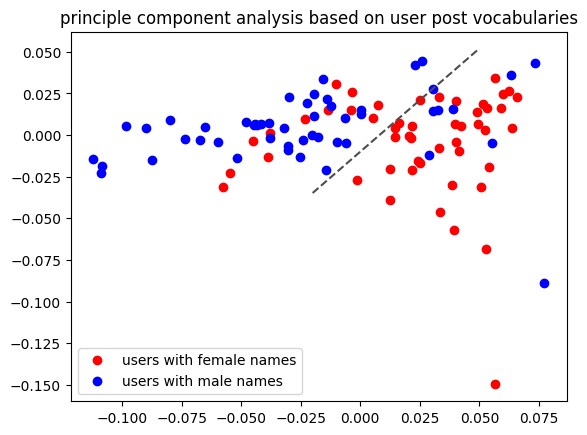

In [41]:
GENDER_BOUNDARY = 50
LINE_X_START = -0.02
LINE_X_END = 0.05

x = [pair[0] for pair in pca_gender_results]
y = [pair[1] for pair in pca_gender_results]
fig, ax = plt.subplots()
plt.plot(x[GENDER_BOUNDARY:], y[GENDER_BOUNDARY:], 'ro', label='users with female names')
plt.plot(x[:GENDER_BOUNDARY], y[:GENDER_BOUNDARY], 'bo', label='users with male names')
plt.plot((LINE_X_START, LINE_X_END), 
         (line_function(LINE_X_START, best_factor, best_offset), 
          line_function(LINE_X_END, best_factor, best_offset)), ls="--", c=".3")
plt.title("principle component analysis based on user post vocabularies")
plt.legend()
plt.savefig("pcp.png")
plt.show()

In [42]:
def evaluate_line(factor, offset, x_list, y_list, names):
    score = 0
    for x, y, name in zip(x_list, y_list, names):
        y_line = factor * x + offset
        if (y >= y_line) and (name in names[:int(0.5*len(names))]):
            score += 1
        elif (y < y_line) and (name not in names[:int(0.5*len(names))]):
            score += 1
    return score

In [43]:
def test_line_position(factor, offset):
    no_improvement = False
    while not no_improvement:
        no_improvement = True
        score_base = evaluate_line(factor, offset, x, y, male_names + female_names)
        for increment in range(1, 2000):
            increment = round(increment / 1000, 2)
            if evaluate_line(factor, offset + increment, x, y, male_names + female_names) > score_base:
                offset += increment
                no_improvement = False
                continue
        for increment in range(-1, -2000, -1):
            increment = round(increment / 1000, 2)
            if evaluate_line(factor, offset + increment, x, y, male_names + female_names) > score_base:
                offset += increment
                no_improvement = False
                continue
        for increment in range(1, 2000):
            increment = round(increment / 1000, 2)
            if evaluate_line(factor + increment, offset, x, y, male_names + female_names) > score_base:
                factor += increment
                no_improvement = False
                continue
        for increment in range(-1, -2000, -1):
            increment = round(increment / 1000, 2)
            if evaluate_line(factor + increment, offset, x, y, male_names + female_names) > score_base:
                factor += increment
                no_improvement = False
                continue
    print(f'score: {score_base}; factor: {round(factor, 3)}; offset: {round(offset, 2)}')

In [44]:
for factor in [0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 5, 7, 10, 15, 20]:
    test_line_position(factor, 0)

score: 79; factor: 1.69; offset: -0.02
score: 79; factor: 1.7; offset: -0.02
score: 79; factor: 1.7; offset: -0.02
score: 79; factor: 1.7; offset: -0.02
score: 80; factor: 1.24; offset: -0.01
score: 79; factor: 0.9; offset: 0
score: 79; factor: 0.9; offset: 0
score: 79; factor: 1.5; offset: 0
score: 79; factor: 1.72; offset: -0.02
score: 79; factor: 2.5; offset: 0
score: 79; factor: 3; offset: 0
score: 79; factor: 5; offset: 0
score: 79; factor: 7; offset: 0
score: 79; factor: 10; offset: 0
score: 79; factor: 15; offset: 0
score: 79; factor: 17.05; offset: 0.1


## 8. Search for topics: tests

In [17]:
def smooth(my_list, n):
    smoothed_list = []
    for index in range(0, len(my_list)):
        list_min = max(0, index - n)
        list_max = min(len(my_list) - 1, index + n)
        smoothed_list.append(sum(my_list[list_min: list_max + 1]) / (list_max - list_min + 1))
    return smoothed_list

In [18]:
class TestNotebook(unittest.TestCase):    
    def test_smooth(self):
        self.assertEqual(smooth([1, 2, 3], 0), [1, 2, 3])
        self.assertEqual(smooth([1, 2, 3], 1), [1.5, 2, 2.5])
        self.assertEqual(smooth([1, 2, 3], 2), [2, 2, 2])

unittest.main(argv=[''], verbosity=2, exit=False)

test_smooth (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


In [43]:
def token_count(post_texts):
    matched_texts = [post_texts[date][key]["text"] 
                     for date in post_texts.keys() 
                     for key in post_texts[date].keys()]
    return pd.Series(" ".join(matched_texts).lower().split()).value_counts()

In [ ]:
print("Most frequent words:")
token_freqs = token_count(post_texts)
token_freqs.head(30)

Most frequent words:
debug 1
debug 2


In [29]:
hashtag_counts = count_hashtags([post_texts[date][key]['text'] 
                                 for date in post_texts.keys() 
                                 for key in post_texts[date].keys()])

In [30]:
hashtag_counts.head(25)

#nieuws             50272
#vacature           41327
#rtlnieuws          19273
#algemeendagblad    15729
#rotterdam           7760
#nos                 5774
#trump               5671
#natuur              5205
#efteling            4931
#photography         4714
#sportnieuws         4627
#update              4590
#randstad            4522
#tda25               4350
#amsterdam           4116
#groningen           3883
#nu.nl               3858
#almelo              3837
#pvv                 3208
#utrecht             2970
#ajax                2931
#fotografie          2871
#olympia             2636
#bbb                 2421
#wilders             2376
Name: count, dtype: int64

|   | count | word | English |
| - | ----- | ---- | ------- |
|  1 | 84878 | Trump* | Trump |
|  2 | 37633 | Wilders* | Dutch politician |
|  3 | 36697 | PVV* | Dutch political party |
|  4 | 35175 | oorlog* | war |
|  5 | 26927 | Israël* | Israel |
|  6 | 22540 | Oekraïne* | Ukraine |
|  7 | 21917 | extreem* | extremism |
|  8 | 19927 | gaza* | Gaza |
|  9 | 19610 | klimaat* | climate |
| 10 | 15220 | democratie* | democracy |
| 11 | 13727 | genocide* | genocide |
| 12 | 12189 | vrijheid* | freedom |
| 13 | 11870 | rechten* | rights |
| 14 | 10344 | protest* | protest |
| 15 | 8698 | woke*| woke |
| 16 | 7426 | milieu* | environment |
| 17 | 6225 | racisme* | racism |
| 18 | 2901 | discriminatie*| discrimination |
| 19 | 2535 | MAGA | Make American Great Again |
| 20 | 901 | slavernij* | slavery |
| 21 | 845 | uitbuiting* | exploitation |
| 22 | 359 | facisme* | facism |
| 23 | 240 | America First | America First |
| 24 | 149 | metoo | metoo |
| 25 | 93 | blm | black lives matter |

*: also count partial match

In [33]:
exact_match = False

for query in """pvv wilders oorlog trump extreem klimaat israël oekraïne democratie vrijheid racisme rechten gaza
                genocide protest milieu discriminatie woke slavernij uitbuiting fascisme nethanyahu paus""".split():
    print(query, end=' ')
    count_word(post_texts, query, exact_match=exact_match)

pvv Found 34810 posts
wilders Found 36183 posts
oorlog Found 34168 posts
trump Found 83975 posts
extreem Found 21194 posts
klimaat Found 18700 posts
israël Found 25991 posts
oekraïne Found 22014 posts
democratie Found 14801 posts
vrijheid Found 11771 posts
racisme Found 5817 posts
rechten Found 11485 posts
gaza Found 19638 posts
genocide Found 13501 posts
protest Found 10034 posts
milieu Found 7169 posts
discriminatie Found 2766 posts
woke Found 8517 posts
slavernij Found 845 posts
uitbuiting Found 812 posts
fascisme Found 8375 posts
nethanyahu Found 201 posts
paus Found 7218 posts


In [39]:
for query in "extre".split():
    print(query, end=' ')
    count_word(post_texts, query, exact_match=exact_match)

extre Found 26906 posts


In [31]:
exact_match = True

for query in "metoo blm".split():
    print(query, end=' ')
    count_word(post_texts, regex.sub('_', ' ', query), exact_match=exact_match)

metoo Found 145 posts
blm Found 88 posts


In [22]:
def count_posts_per_hour(post_texts, query="", return_weekdays=False, exact_match=True):
    matched_hours = find_word(post_texts, query, n=sys.maxsize, 
                              print_texts=False, exact_match=exact_match, 
                              return_hours=not return_weekdays, return_weekdays=return_weekdays)
    data_per_hour = pd.Series(matched_hours).value_counts()
    return data_per_hour

Takes about 3 minutes:

In [23]:
base_hour_data = count_posts_per_hour(post_texts)

Found hours for 4207642 posts


Takes about 3 minutes:

In [127]:
base_weekday_data = count_posts_per_hour(post_texts, return_weekdays=True)

Found texts for 4399383 posts


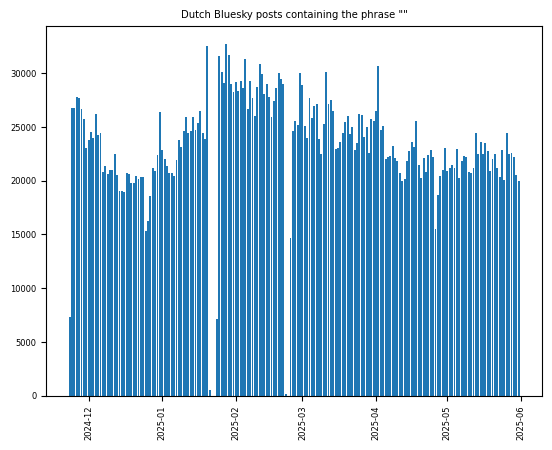

In [128]:
query = ""
exact_match = True
bar_plot(count_word(post_texts, query, exact_match=exact_match), query=query)

In [37]:
post_texts_december = {date: post_texts[date] for date in post_texts.keys() if date in ['2024-12-01', '2024-12-02', '2024-12-03', '2024-12-04', '2024-12-05', '2024-12-06', '2024-12-07',
                                                                                        '2024-12-08', '2024-12-09', '2024-12-10', '2024-12-11', '2024-12-12', '2024-12-13', '2024-12-14',
                                                                                        '2024-12-15', '2024-12-16', '2024-12-17', '2024-12-18', '2024-12-19', '2024-12-20', '2024-12-21',]}

takes about 15 seconds:

Found 1522 posts


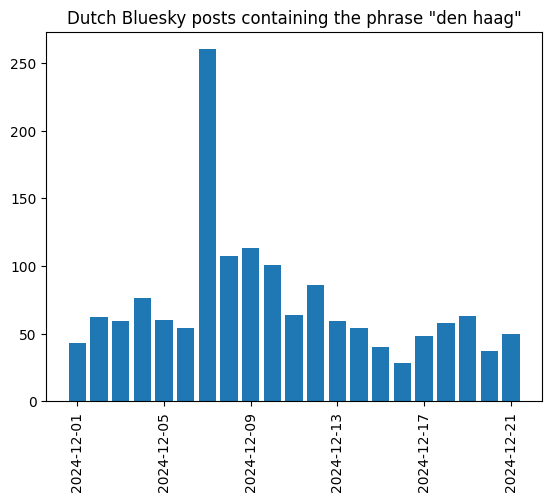

In [42]:
query = "den haag"
exact_match = True
bar_plot(count_word(post_texts_december, query, exact_match=exact_match), query=query)

spikes for "Den Haag"
* 7 December 2024: https://nl.wikipedia.org/wiki/Aanslag_in_Den_Haag_op_7_december_2024
* 18 May 2025: https://nl.wikipedia.org/wiki/Rode_Lijn-demonstratie

In [39]:
matched_texts = find_word(post_texts_december, query, n=sys.maxsize, 
                          print_texts=False, exact_match=exact_match, return_hours=False)

Found texts for 1522 posts


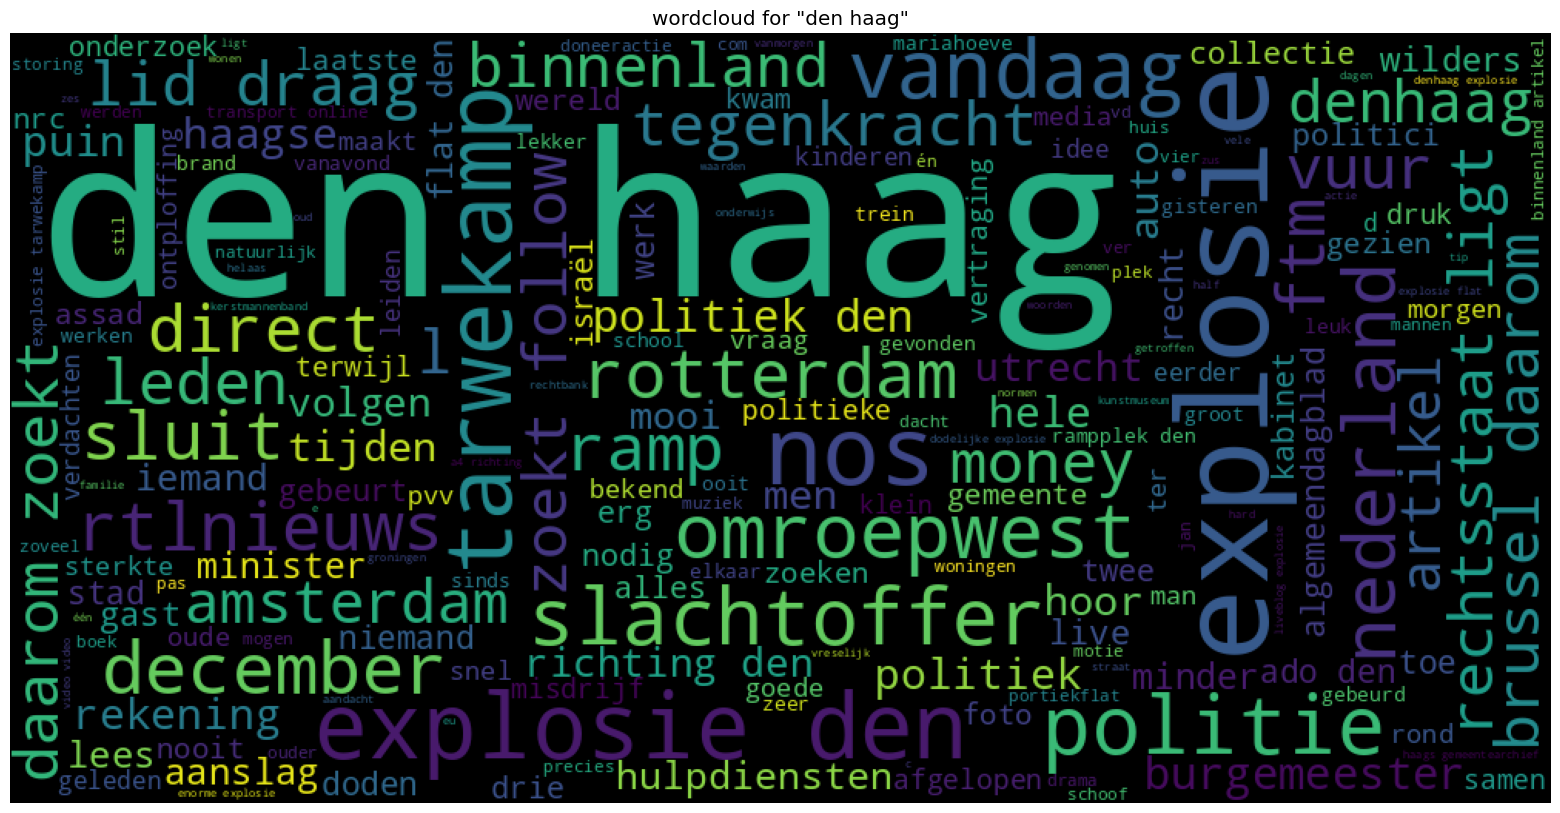

In [40]:
show_wordcloud(" ".join(matched_texts).lower(), stopwords=stopwords, title=f'wordcloud for "{query}"')

In [24]:
def hour_plot(matched_hours, base_hour_data, query=""):
    hour_data = {hour: matched_hours[hour] / base_hour_data[hour] 
                 for hour in sorted(matched_hours.keys())}
    x = hour_data.keys()
    y = smooth(list(hour_data.values()), 0)
    plt.figure(figsize=[5, 3.5])
    plt.plot(x, y, label=query)
    plt.xticks(range(0, len(base_hour_data)))
    plt.title(f'relative frequency of "{query}" per hour of the day')
    plt.savefig('fig.png')
    plt.show()

Found hours for 21216 posts


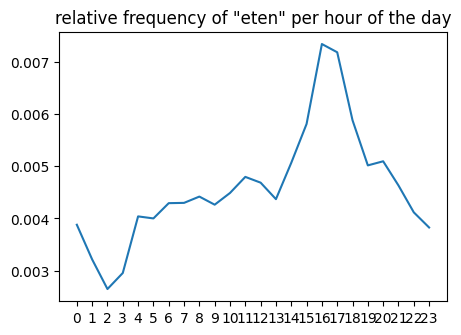

In [28]:
query = "eten"
matched_hours = count_posts_per_hour(post_texts, query)
hour_plot(matched_hours, base_hour_data, query=query)

In [121]:
def week_plot(matched_hours, base_hour_data, query=""):
    hour_data = {hour: matched_hours[hour] / base_hour_data[hour] 
                 for hour in sorted(matched_hours.keys())}
    x = hour_data.keys()
    y = smooth(list(hour_data.values()), 0)
    plt.figure(figsize=[5, 3.5])
    plt.bar(x, y, label=query)
    plt.xticks(ticks=range(0, 7),
               labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], 
               rotation=90)
    plt.title(f'relative frequency of "{query}" per day of the week')
    plt.savefig('fig.png')
    plt.show()

In [102]:
query = "wedstrijd"

In [103]:
matched_weekdays = count_posts_per_hour(post_texts, query, return_weekdays=True)

Found texts for 5334 posts


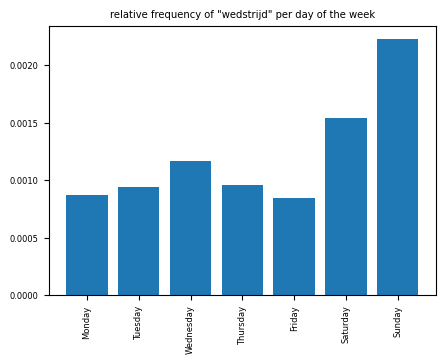

In [122]:
week_plot(matched_weekdays, base_weekday_data, query=query)

## 9. Look for associated words

In [35]:
def get_random_sample(post_texts, sample_size, omit_phrase, min_size=10000):
    post_texts_list = [post_texts[date][key]["text"] for date in post_texts for key in post_texts[date].keys()]
    random_sample = []
    while len(random_sample) < sample_size or len(random_sample) < min_size:
        random_id = random.randint(0, len(post_texts_list) - 1)
        if omit_phrase == "" or not regex.search(f'\\b{omit_phrase}\\b', post_texts_list[random_id], regex.IGNORECASE):
            random_sample.append(post_texts_list[random_id])
    return random_sample

In [36]:
NBR_OF_WORDS = 30

def show_associated_tokens(post_texts, query, nbr_of_words=NBR_OF_WORDS, exact_match=True):
    matched_texts = find_word(post_texts, query, n=sys.maxsize, 
                              print_texts=False, exact_match=exact_match, return_hours=False)
    random_sample = get_random_sample(post_texts, len(matched_texts), query)
    return list(compute_token_tscores("\n".join(random_sample), "\n".join(matched_texts)).items())[:nbr_of_words]

In [38]:
show_associated_tokens(post_texts, "extre", exact_match=False)

Found texts for 26906 posts


[('extreem', -97.27146494930705),
 ('extreemrechts', -76.86772023887774),
 ('rechts', -67.40844638811105),
 ('extreemrechtse', -65.08900601494409),
 ('extreme', -45.55060656389459),
 ('rechtse', -39.76971049557716),
 ('links', -35.94789134129579),
 ('extreem-rechts', -29.776844239688195),
 ('en', -24.024545998707822),
 ('kabinet', -22.67835517220204),
 ('extremisten', -22.10733405286656),
 ('extremistische', -21.767017257440994),
 ('afd', -21.71292553349165),
 ('extreem-rechtse', -21.653072108493348),
 ('partijen', -21.59510930622452),
 ('partij', -21.581660771916976),
 ('extremisme', -20.850760502231456),
 ('pvv', -20.648491710699947),
 ('vvd', -19.838775519919523),
 ('is', -19.320708717337837),
 ('linkse', -19.001050739287127),
 ('extreemlinks', -18.86608239284334),
 ('wilders', -18.560630902610672),
 ('democratie', -17.97580370642823),
 ('macht', -17.970420485046592),
 ('tegen', -17.296469266634134),
 ('extremen', -17.2024606028859),
 ('fascistische', -17.179173261534086),
 ('media'

Political and social issues, number of posts
* 18875 oorlog
* 14123 democratie
* 13861 racisme+
* 12649 genocide
* 9957 vrijheid
* 8250 woke
* 7848 vrede
* 4476 antisemitisme+
* 2042 dictatuur
* 1793 abortus+
* 1582 rechtstaat
* 1401 etnische zuivering
* 1142 onderdrukking
* 901 slavernij+
* 799 autocratie
* 734 fascisme+
* 694 kolonialisme+
* 692 euthanasie+
* 149 metoo
* 93 blm
  
Organizations
* 28244 eu
* 8967 navo
* 7019 hamas
* 465 hezbollah

Geographical areas
* 32135 vs
* 30576 europa
* 21134 oekraine
* 20752 israël
* 19192 rusland
* 17924 gaza
* 10864 amerika
* 9064 china
* 4533 canada
* 2889 groenland
* 2842 palestina
* 2243 iran
* 2005 mexico
* 587 west bank
* 381 jemen

Dutch politicians
* 36610 wilders
* 16956 faber
* 13896 schoof
* 9528 rutte
* 8602 omtzigt 
* 5385 timmermans
* 4852 van der plas
* 3510 yesilgöz 
* 1405 bontenbal
* 1083 jetten
* 669 klaver
* 685 bikker

International politicians
* 78100 trump
* 18640 musk
* 12439 poetin
* 7229 zelensky
* 6384 paus
* 4643 vance
* 1841 orban
* 931 erdogan
* 797 xi
* 718 von der leyen
* 210 nethanyahu
* 142 modi
* 66 kim
* 33 bin salman